## HLS Product Validation and Comparison Notebook
# Introduction

This notebook provides a workflow for validating and comparing Harmonized Landsat and Sentinel-2 (HLS) satellite products. It is designed to evaluate differences between older and newer HLS versions through both visual and statistical analyses. The workflow includes steps for data loading, preprocessing, visualization, and quantitative assessment using selected test sites and temporal samples. By following this notebook, users can identify improvements, inconsistencies, or biases between HLS product versions and ensure the reliability of the updated datasets for downstream applications.

# Outline:
1. Data Preparation:


2. Data Loading and Preprocessing:
 


3. Visual Comparison:



4. Statistical Evaluation:




## 1. Data preparation:
- Define data sources and input directories  
- List HLS products and versions being compared  
- Select test sites and time periods  
- Import required Python libraries

Use either way to import python libraries 

In [ ]:
# Method 1: Import using environment.yml 
mamba env create -f environment.yml


In [ ]:
# Method 2: directly install packages using mamba/conda 
mamba create -n lpdaac_vitals -c conda-forge --yes python=3.12 gdal fiona boto3 hvplot geoviews rioxarray rasterio jupyter geopandas earthaccess jupyter_bokeh h5py h5netcdf spectral scikit-image jupyterlab seaborn dask ray-default pystac-client odc-stac pyresample libgdal-hdf4 harmony-py


Next, activate the Python Environment that you just created.

In [ ]:
mamba activate lpdaac_vitals 

Now, import the libraries and packages 

In [33]:
import rasterio
import os
import matplotlib.pyplot as plt
import glob
import numpy as np
import matplotlib.image as mpimg
import matplotlib.colors as colors
from datetime import datetime
import pandas as pd
import seaborn as sns
import copy

%run -i ./module/plotting.ipynb
%run -i ./module/data_access.ipynb
%run -i ./module/algorithm.ipynb
%run -i ./module/ultilities.ipynb
%run -i ./module/fmask.ipynb
#This environment varialbe is necessary for anonymous s3 driver access to the bucket.
%env AWS_NO_SIGN_REQUEST=YES

env: AWS_NO_SIGN_REQUEST=YES


In [5]:
folders ='/home/jovyan/shared-public/recovered/hls-validation/sample_data/'

# Define a folder directory for pre-product (e.g., Fmask_v47)
# folder_pre =  '/home/jovyan/shared-public/recovered/hls-validation/sample_data/fmask4.7/'
folder_pre = 's3://hls-debug-output/Fmask4_outputs/Sentinel-2/'

# Define a folder directory for post-product (e.g., Fmask_v5)
#folder_post = '/home/jovyan/shared-public/recovered/hls-validation/sample_data/fmask5_May2025/'
folder_post = 's3://hls-debug-output/Fmask5_outputs/Sentinel-2/'

## 2. Data Loading and Preprocessing:

- Load HLS scenes (e.g., HLSL30, HLSS30)  
- Apply cloud masking or quality filtering  
- Align datasets spatially and temporally  
- Extract relevant spectral bands or indices (e.g., NDVI, NIR)  

To read files from an S3 bucket anonymously in Python, you can use the boto3 library with the botocore.UNSIGNED configuration.

In [6]:
bucket_name = 'hls-debug-output'
prefix_fmask5 = '/'.join(folder_post.split('/')[3:])
prefix_fmask4 = '/'.join(folder_pre.split('/')[3:])
files_s3_fmask5 = list_all_s3_files_anonymous(bucket_name, prefix=prefix_fmask5)
files_s3_fmask4 = list_all_s3_files_anonymous(bucket_name, prefix=prefix_fmask4)
len(files_s3_fmask4), len(files_s3_fmask5)

(2461, 854)

In [4]:
fmask5_ids = np.unique([i.split('.')[2] for i in files_s3_fmask5])

In [5]:
fmask4_ids = np.unique([i.split('.')[2] for i in files_s3_fmask4 if i.endswith('.tif')])

In [6]:
common_ids = list(set(fmask5_ids) & set(fmask4_ids))

In [ ]:
common_ids

## 3. Visual Comparison:
- Display sample RGB and a certain band  
- Side-by-side visualization of old vs new products  
- Difference maps to highlight pixel-level changes  

In [7]:
# Get a list of unique granule/tile ID 
days = np.unique([i.split('.')[3] for i in files_s3_fmask5])

# get the percentage coverage of each fmask feature for each fmask version 
df_fmask_percentage = get_fmask_percentage_compare(files_s3_fmask5, files_s3_fmask4, days)

No matching for this granules between Fmask 4 and 5 for this mrgs ID on this date 2018196
No matching for this granules between Fmask 4 and 5 for this mrgs ID on this date 2018209
No matching for this granules between Fmask 4 and 5 for this mrgs ID on this date 2018219
No matching for this granules between Fmask 4 and 5 for this mrgs ID on this date 2018283
No matching for this granules between Fmask 4 and 5 for this mrgs ID on this date 2018319
No matching for this granules between Fmask 4 and 5 for this mrgs ID on this date 2018346
No matching for this granules between Fmask 4 and 5 for this mrgs ID on this date 2018351
No matching for this granules between Fmask 4 and 5 for this mrgs ID on this date 2018355
No matching for this granules between Fmask 4 and 5 for this mrgs ID on this date 2018360
No matching for this granules between Fmask 4 and 5 for this mrgs ID on this date 2019002
No matching for this granules between Fmask 4 and 5 for this mrgs ID on this date 2019004
No matchin

Performing the plotting for a certain MRGS ID:

https://github.com/NASA-IMPACT/hls_development/issues/358

As defined by Qiang for testing: 

- 31UDQ Urban, cropland;

- 10UEV Urban, mountain with permanent snow;

- 11SLT Urban, mountains;

- 42QWM Coast, bright sand

We select some indivual case and plot True color composite, Cirrus, Fmask4 and 5, and statistical comparision

In [8]:
mrgs_id_target = '31UDQ'

# get list of files for fmask 5 and fmask 4 for this id

files_fmask5_test, files_fmask4_test, day_uniques, day_uniques_julian = filter_fmask_files(
    files_s3_fmask5, files_s3_fmask4, mrgs_id_target, to_julian_date
)

Important:

To have a interactive interface for comparision, it is suggested to use 'qt5' on notebook by running this following cell: %matplotlib qt

In [58]:
%matplotlib inline

/var/folders/qq/g5z8h46d6ldfjb7csbf4q6z40000gn/T/ipykernel_79101/142216088.py:85: RuntimeWarning: invalid value encountered in cast
  fmask = fmask.astype(np.uint8)
/var/folders/qq/g5z8h46d6ldfjb7csbf4q6z40000gn/T/ipykernel_79101/142216088.py:85: RuntimeWarning: invalid value encountered in cast
  fmask = fmask.astype(np.uint8)
/var/folders/qq/g5z8h46d6ldfjb7csbf4q6z40000gn/T/ipykernel_79101/317765679.py:65: RuntimeWarning: invalid value encountered in cast
  return arr.astype(np.uint8)
/var/folders/qq/g5z8h46d6ldfjb7csbf4q6z40000gn/T/ipykernel_79101/317765679.py:82: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap).copy()
/var/folders/qq/g5z8h46d6ldfjb7csbf4q6z40000gn/T/ipykernel_79101/142216088.py:85: RuntimeWarning: invalid value encountered in cast
  fmask = fmask.astype(np.uint8)
/var/

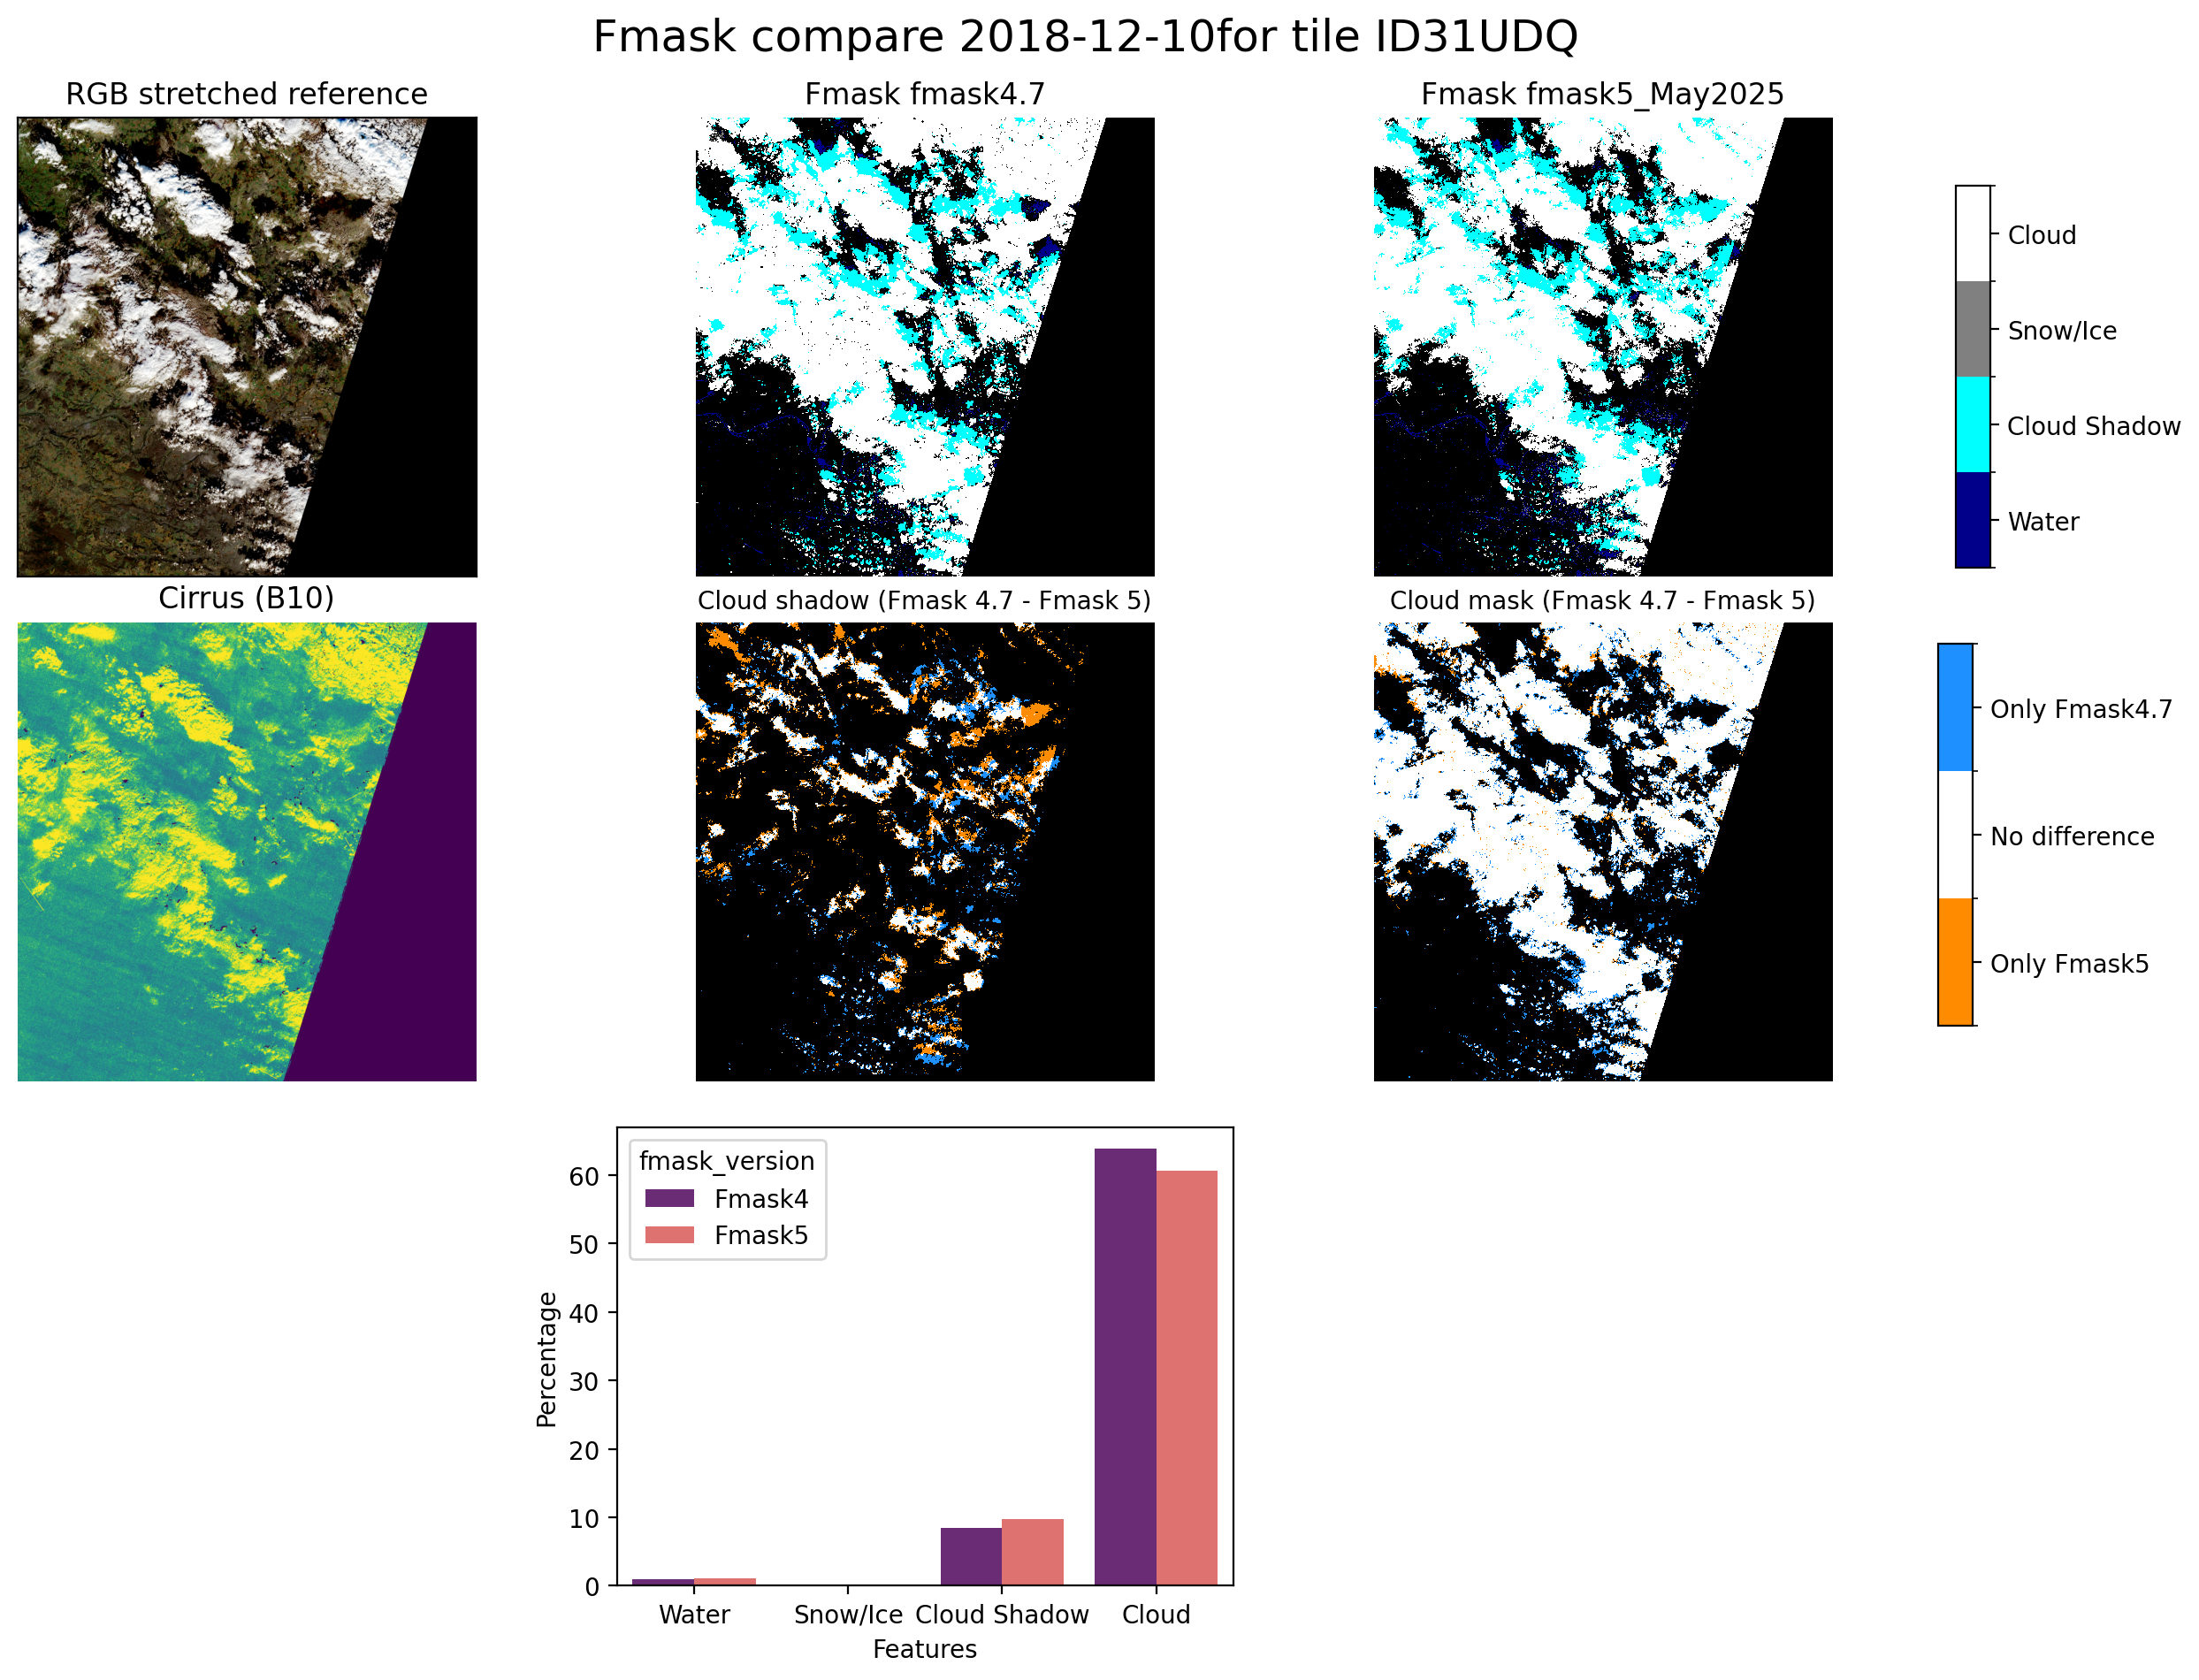

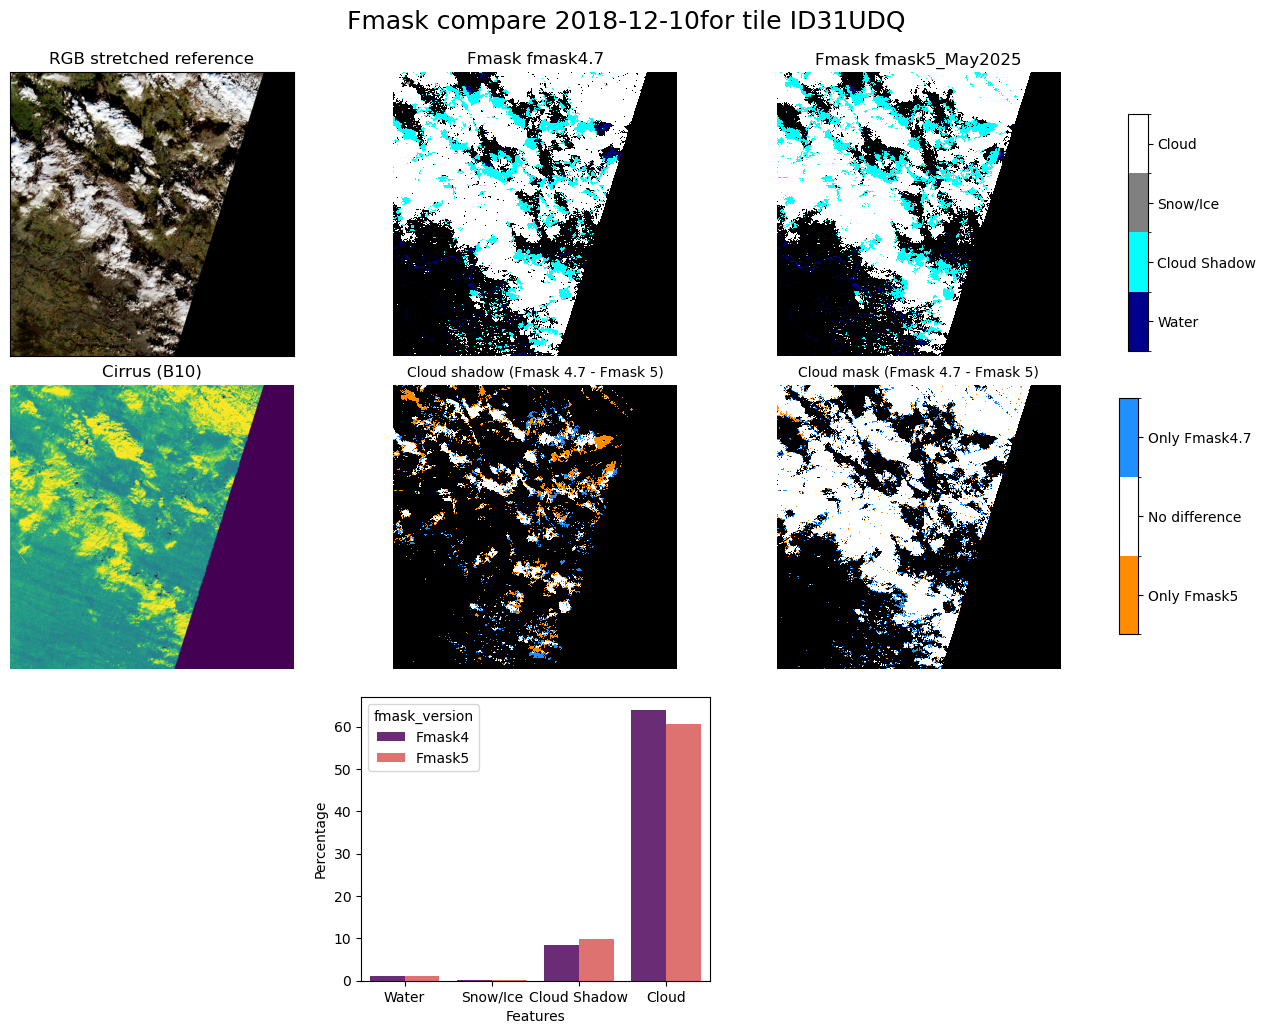

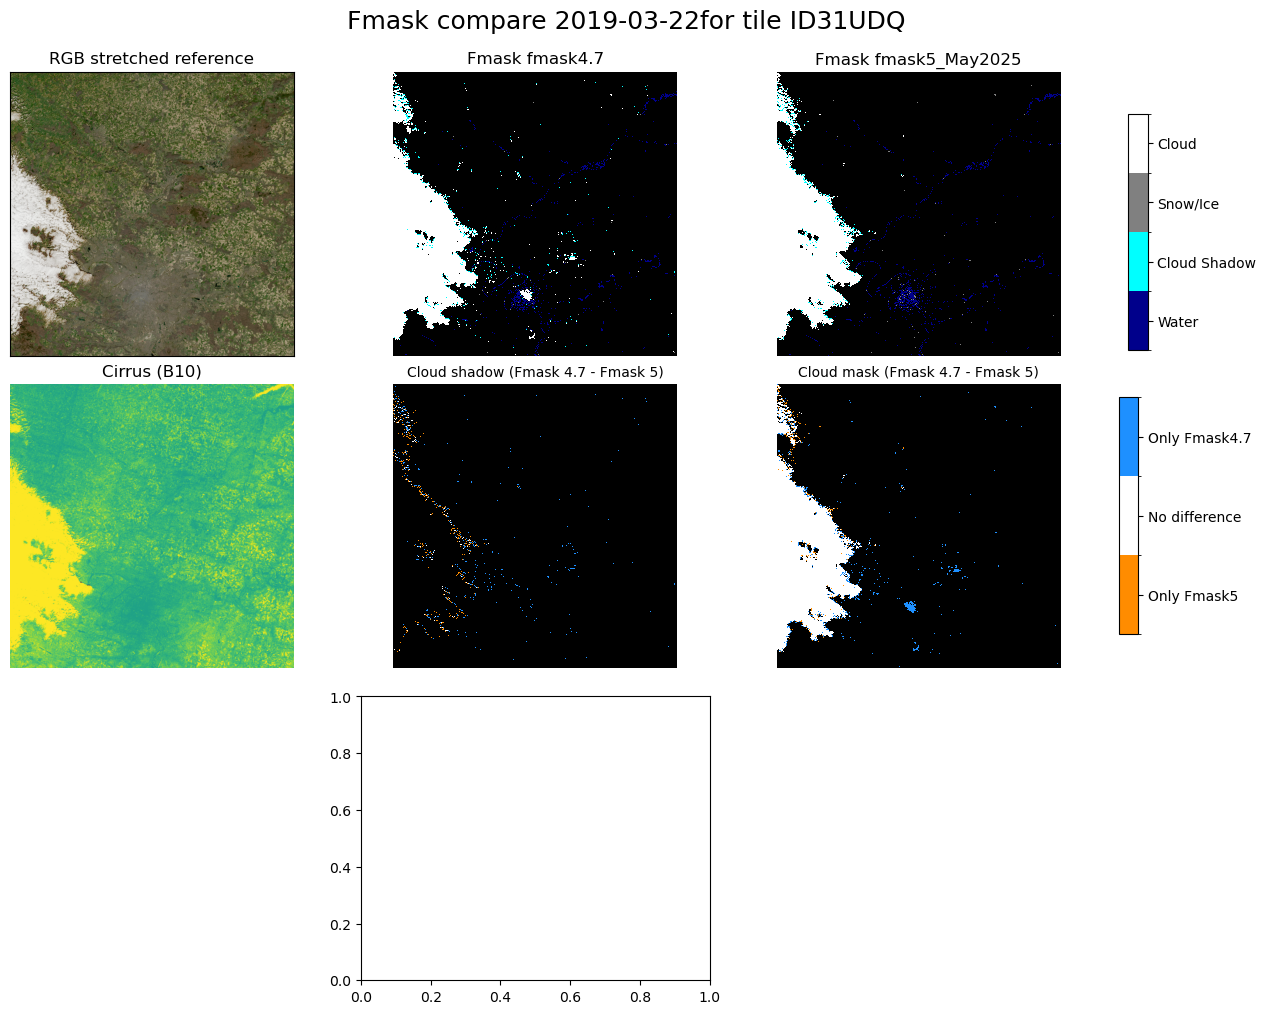

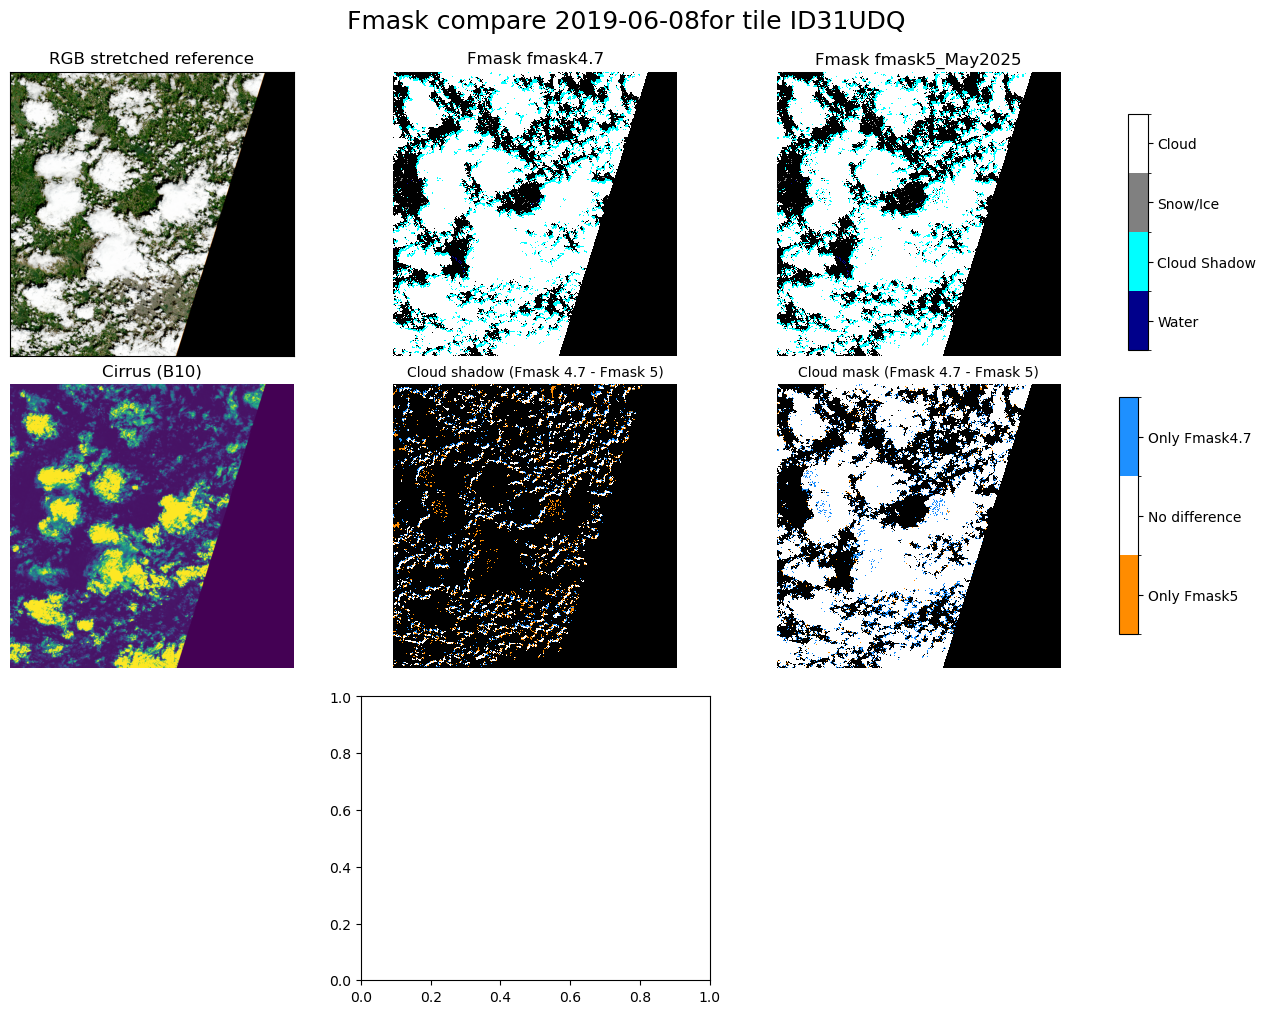

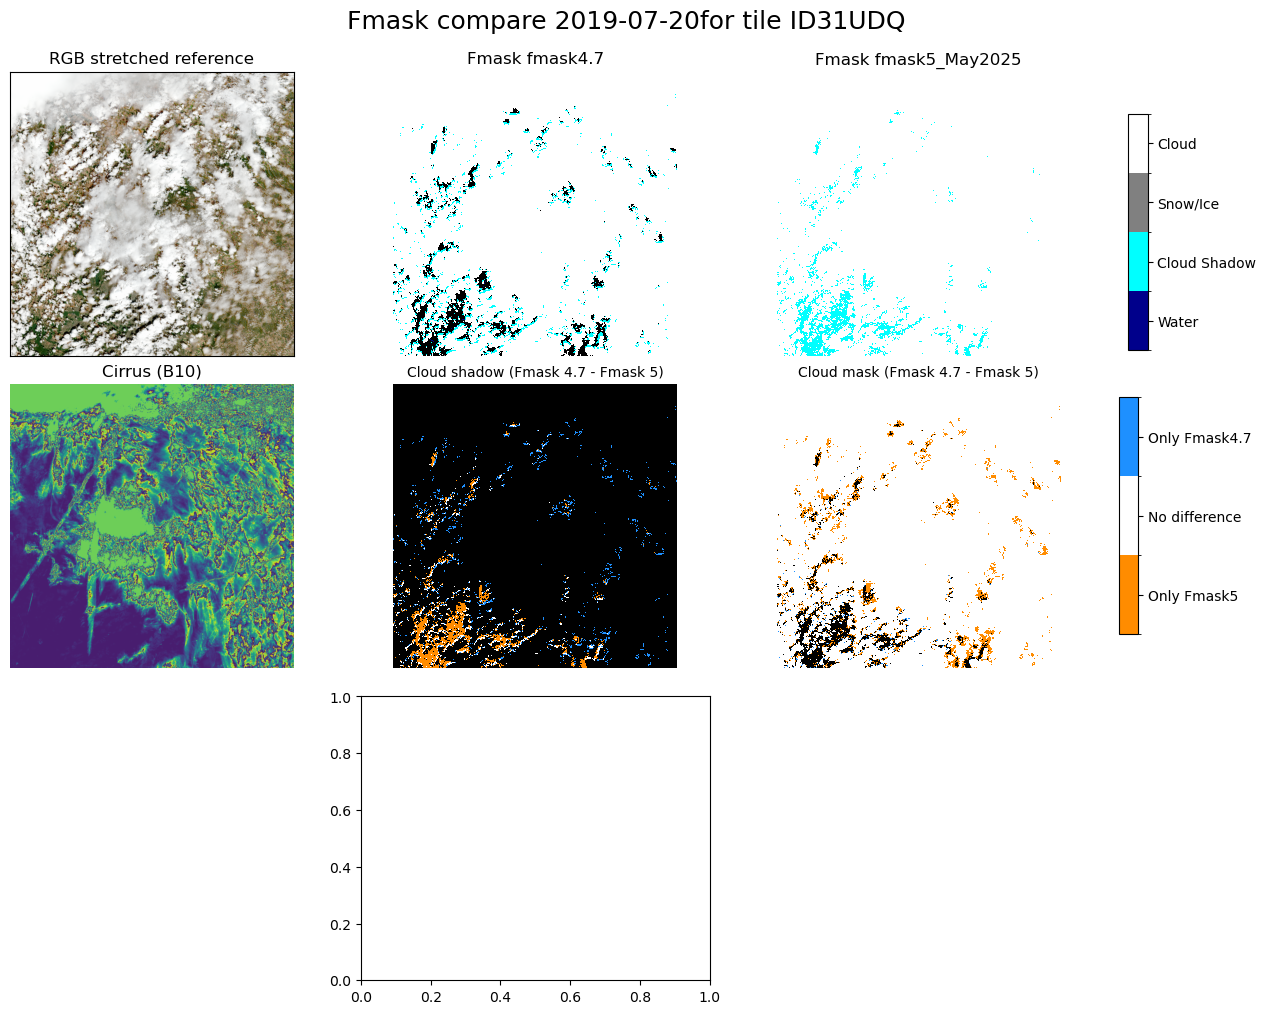

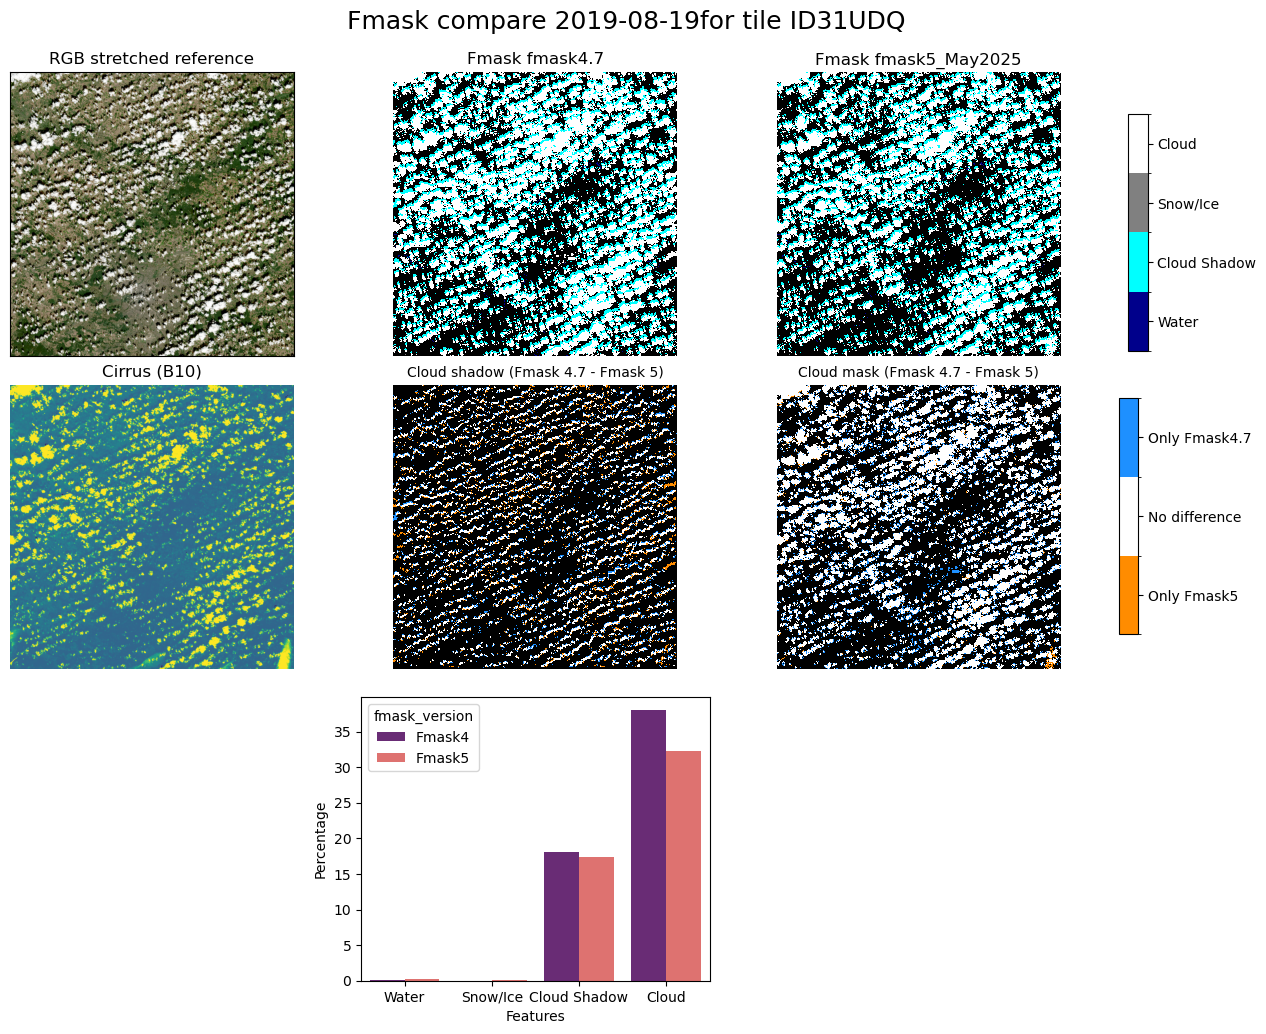

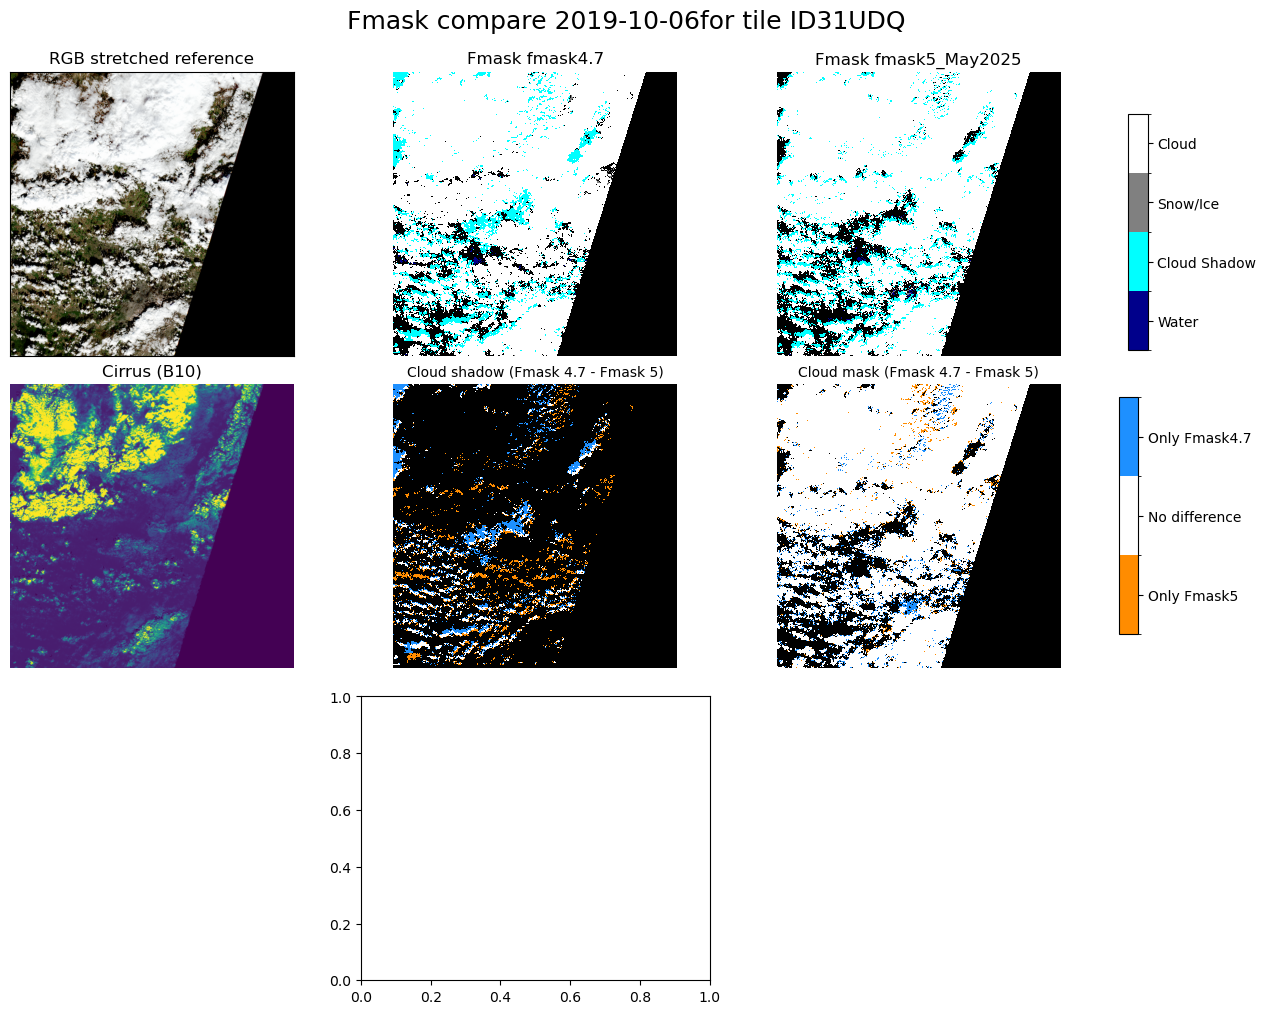

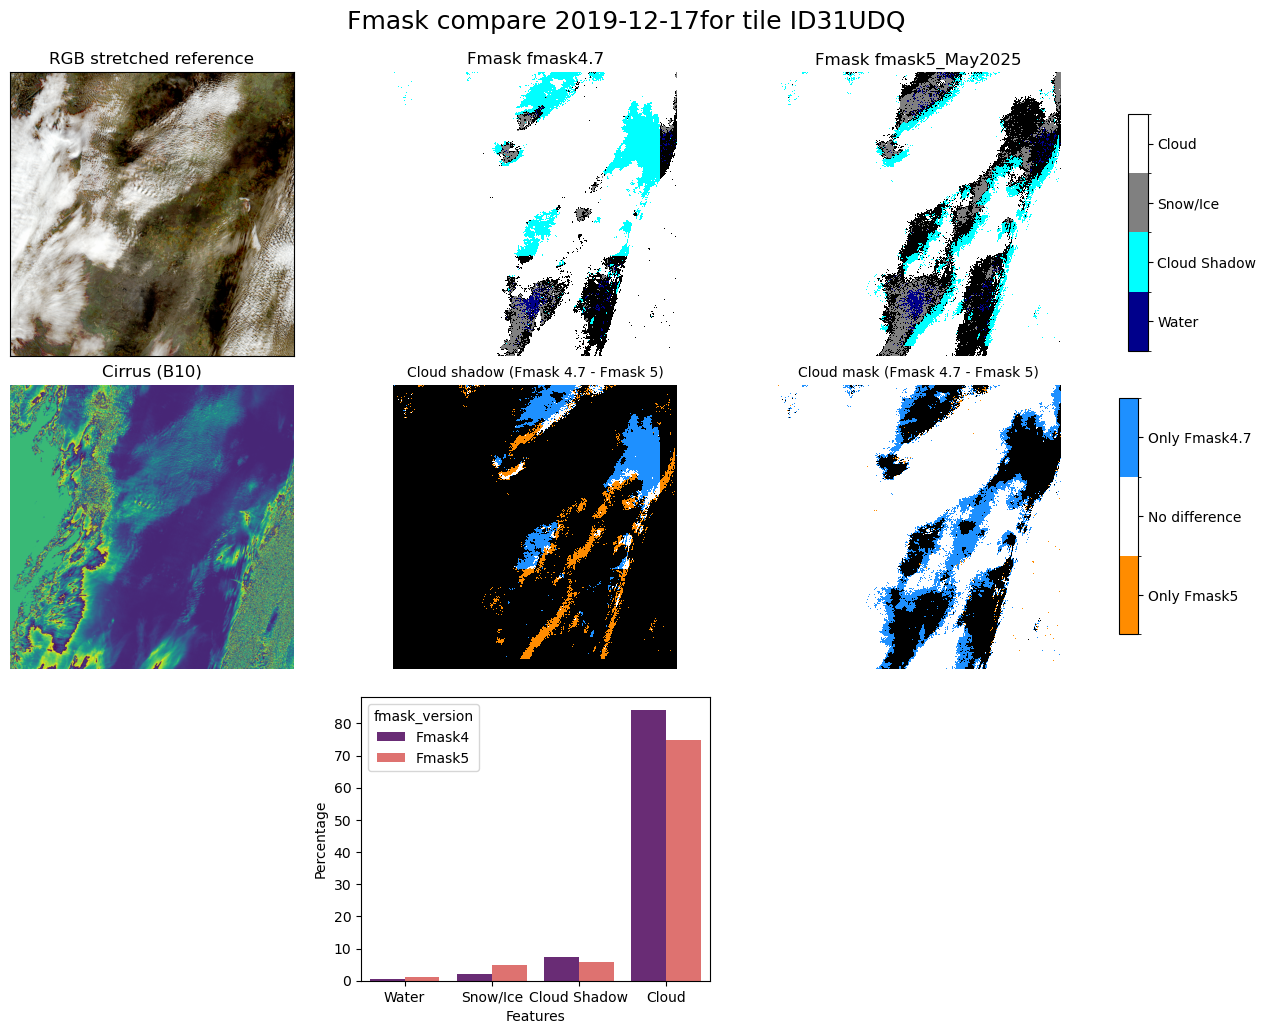

In [59]:
# Looping over each unique day to plot each granule for comparision 
for day in day_uniques[::2]:
    
    fig, axes = plt.subplots(figsize=(12.97, 10.44),
                             #sharex=True,
                             #sharey=True,
                             ncols=3,
                             nrows=3
                             )
    
    axes = [i for ax in axes for i in ax]

    # Part 1: Plot RGB, Fmask4, Fmask5, and Cirrus bands 
    raster_list = list()
    for i in range(4):
        
        fmask_version = get_fmask_info(i=i)['fmask_version']
        title = get_fmask_info(i=i)['title']
  
        ax = axes[i]
        
        ax.set_title(title)

        # Get file path based on fmask version and types
        file_path = select_fmask_files(fmask_version=fmask_version,
                                    day=day,
                                    files_fmask4_test=files_fmask4_test,
                                    files_fmask5_test=files_fmask5_test,
                                    day_uniques=day_uniques,
                                    day_uniques_julian=day_uniques_julian
                                )
        # get the reference file of fmask 4 for spatial extent reference
        fmask4_ref = select_fmask_files(fmask_version='fmask4.7',
                                    day=day,
                                    files_fmask4_test=files_fmask4_test,
                                    files_fmask5_test=files_fmask5_test,
                                    day_uniques=day_uniques,
                                    day_uniques_julian=day_uniques_julian
                                )
        
        # Read the file path as raster
        raster = read_raster_or_rgb(file_path, bucket_name, read_true_color_from_files, fmask4_ref)

        
        raster_list.append(raster)


        if i == 0:
            # plot true color composite RGB
            # Assuming rgb_image is your input RGB array
            # stretched_rgb = stretch_rgb(raster)

            # Change: apply log stretching instead of linear stretching
            stretched_rgb = log_stretching_reflectance_optimized(raster)
    
            ax.imshow(stretched_rgb)
            ax.set_title("RGB stretched reference", fontsize=12)

        elif i == 3:
            # plot grey-scale cirrus band
            plot_cirrus_band(ax, raster)
      

        else:

            cax_fmask = plot_fmask_raster(ax, raster, i=i, fig=fig, show_colorbar=(i == 2))
            ax.set_title(f"Fmask "+fmask_version, fontsize=12)
        
                
    # Part 2: plot histogram and actual images to show differences in cloudy and cloud maskpixels between two versions
    # Fmask 47 - Fmask 5
    cax_fmask_diff = plot_fmask_diff(raster_list, axes, fig)

    
    
    # add a barchart show percentage
    plot_fmask_percentage_by_day(day, df_fmask_percentage, axes)
    
    day_convert = datetime.strptime(day, '%Y%j').strftime('%Y-%m-%d')

    # Part 3: final formating 
    fig.suptitle('Fmask compare '+day_convert + 'for tile ID'+mrgs_id_target,
                 size=18)
    
    customize_axes_layout(axes, cax_fmask, cax_fmask_diff, i, fig)


    fig.savefig('figures/'+'Fmask_compare_'+day+'_'+mrgs_id_target+
                '.png',dpi=300)
    

## 4. Statistical Evaluation:
- Compute descriptive statistics (mean, std, RMSE, correlation)  
- Pixel-wise comparison across products  
- Time-series consistency analysis (if multi-date data available)  
- Summary tables and plots  

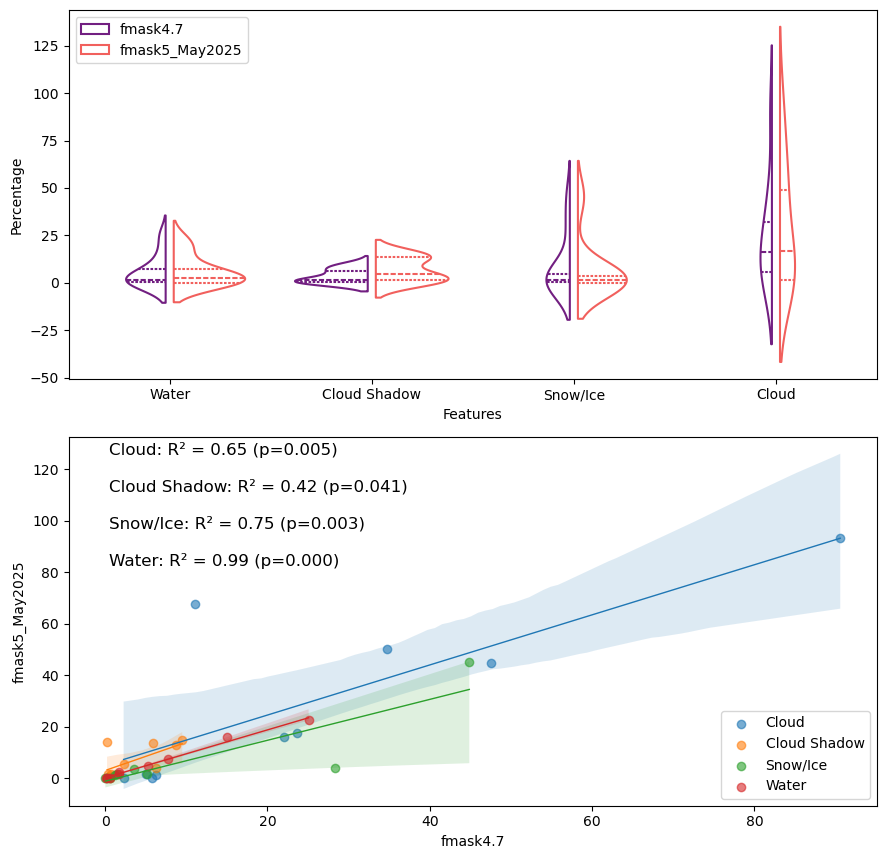

In [23]:
#violin plot show difference in distribution between 47 and 5
fig, axes = plt.subplots(figsize=(8.97, 8.69),
                       nrows=2
                       )

index=0
for ax in axes:
    ax = axes[index]
    if index == 0:
        
        sns.violinplot(data=df_concat_all, 
                   x="Features", 
                   y="Percentage", 
                   hue="fmask_version", 
                   split=True, 
                   #gap=.1, 
                   inner="quart",
                   fill=False,
                   gap=.1,
                   palette='magma',
                   ax=ax
                   )
        
        ax.legend(loc='upper left')
    else:
        df_grp = df_concat_all.groupby(['Date','mrgs_id',
                                        'fmask_version','Features'])
        
        df_grp_mean = df_grp['Percentage'].mean().reset_index()
        df_grp_mean_pivot = df_grp_mean.pivot_table(index=['Date','mrgs_id',
                                                           'Features'
                                                           ],
                                                    columns='fmask_version',
                                                    values='Percentage').reset_index()
        
        y_coors = [0.95,0.85,0.75,0.65]
        k=0
        for class_ in np.unique(df_grp_mean_pivot['Features']):
            df_regplot = df_grp_mean_pivot.loc[df_grp_mean_pivot['Features']
                                               == class_
                                               ]
            
            plot = sns.regplot(data=df_regplot, 
                       x="fmask4.7", 
                       y="fmask5_May2025", 
                       #hue="Features", 
                       #palette=['darkblue','cyan','grey','red'],
                       ax=ax,
                       scatter_kws={'alpha':0.6},
                       line_kws={'linewidth':1},
                       label=class_
                       )
            # The scatter plot is usually the first child of type PathCollection
            scatter_collection = [c for c in ax.collections 
                                  if isinstance(c, plt.cm.ScalarMappable)][0]
            
            # Calculate R-squared
            from sklearn.metrics import r2_score
            from scipy import stats
            
            
            
            x = df_regplot.dropna()['fmask4.7']
            y = df_regplot.dropna()['fmask5_May2025']
            slope, intercept, r_value, p_value, std_err = stats.linregress(x, 
                                                                           y)
            r_squared = r_value**2
            
            # Annotate the plot with the R-squared value
            ax.annotate(class_+': '+ f'R² = {r_squared:.2f} (p={p_value:.3f})', 
                        xy=(0.05, y_coors[k]), 
                        xycoords='axes fraction', 
                        fontsize=12,
                        color = 'black'
                        )
            
            ax.legend(loc='lower right')
            
            k=k+1
            
                    
        
        
    
    index=index+1
plt.tight_layout()

## 5. Does the cloud detection improved over certain features

1. Cloud Commision over bright surface e.g., Urban (Building) footprints
   Fmask 4.7 still faces issues with cloud commission over bright surfaces e.g., building, roofs. To verify whether Fmask 5. improves the detection of clouds over buildings, cloud coverage is estimated over a large sample of urban building footprints over multiple years. If the cloud comission in Fmask 5.0 has been improved, we should expect to see less cloud coverage over time

Below is an example snapshot of cloud commission over bright surface in Fmask 4.7 and how different Fmask 5.0 generally looks like. 
   

(3414.6899228590955, 1234.6293818962995)

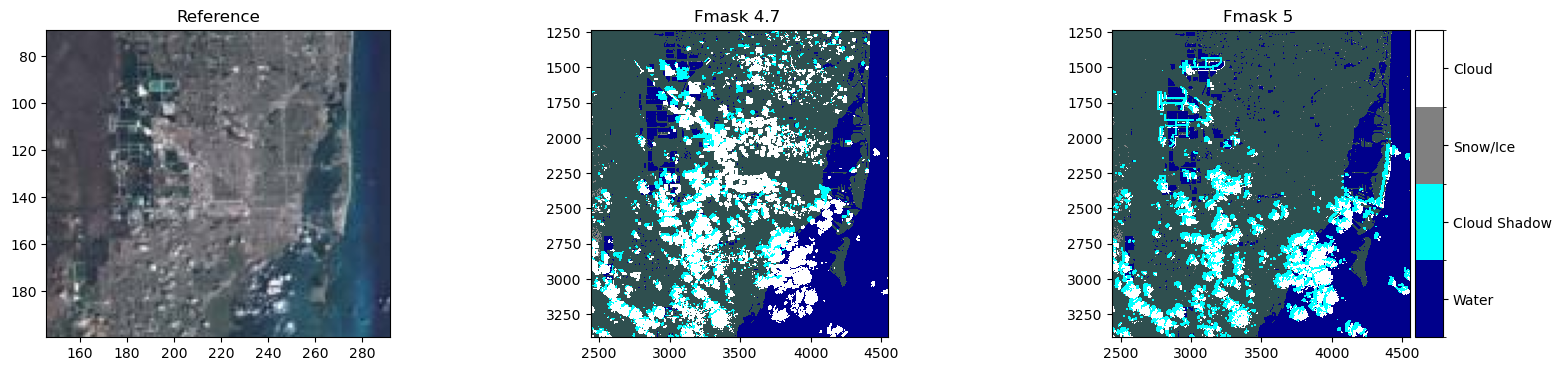

In [24]:
# A test case over urban surfaces
day = days[-2]
fig, axes = plt.subplots(figsize=(19.06,  3.99),
                         #sharex=True,
                         #sharey=True,
                         ncols=3)

raster_list = list()
for i in range(3):

    if i == 0:
        fmask_version = 'fmask4.7'
        title = 'Reference' 

    elif i == 1:
        fmask_version = 'fmask4.7'
        title = 'Fmask 4.7 '
        day_text = day.replace('_',' ') 

    else:
        fmask_version = 'fmask5_May2025'
        title = 'Fmask 5 '
        day_text = day.replace('_',' ') 

    ax = axes[i]

    ax.set_title(title)


    file = glob.glob(folders+fmask_version+'/'+
               '*'+day+'*.tif')[0]
    raster = rasterio.open(file).read(1).astype(np.float16)

    # mask out 255 to nan
    raster[raster == 255] = np.nan
    raster[raster == 0] = np.nan 


    vmin = 0
    vmax = 4

    if i == 0:
        file_thumbnail = glob.glob(folders+fmask_version+'/'+
                   '*'+day+'*.jpg')[0]
        img = mpimg.imread(file_thumbnail,

                           )

        ax.imshow(img)

    else:
        bounds = [1,2,3,4,5]
        #default_cmap = plt.cm.viridis
        #colors_ = default_cmap(np.linspace(0, 1, len(bounds)+1))
        colors_ = ['darkblue','cyan','grey','white']
        custom_listed_cmap = colors.ListedColormap(colors_)
        custom_listed_cmap.set_bad(color='darkslategrey')

        norm = colors.BoundaryNorm(bounds,custom_listed_cmap.N)


        ax.imshow(raster,cmap=custom_listed_cmap,norm=norm,
                  interpolation='nearest')

        if i == 2:

            # Manually define the position and size of the colorbar axes (cax)
            # The arguments are [left, bottom, width, height] in figure coordinates (0 to 1)
            # Adjust these values as needed to position your colorbar
            cax = fig.add_axes([ax.get_position().x1,  # x-position (slightly to the right of the main axes)
                                ax.get_position().y0,         # y-position (aligned with the bottom of the main axes)
                                0.015,                         # width of the colorbar axes
                                ax.get_position().height])    # height of the colorbar axes (same as main axes)


            cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, 
                                                      cmap=custom_listed_cmap), 
                                boundaries=bounds, 
                                #ticks=[i + 0.5 for i in cbar.ax.get_yticks()]
                                cax=cax
                                )

            cbar.ax.set_yticks([1.5,2.5,3.5,4.5])

            cbar.ax.set_yticklabels([ 
                                     'Water', 
                                     'Cloud Shadow',
                                     'Snow/Ice',
                                     'Cloud',

                                     ])
axes[0].set_ylim((199.47448165869218, 68.85247208931418))
axes[0].set_xlim((145.76813327785868, 292.0201268982733))
axes[1].set_xlim((2442.809066709684, 4551.392212886818))
axes[1].set_ylim((3414.6899228590955, 1234.6293818962995))
axes[2].set_xlim((2442.809066709684, 4551.392212886818))
axes[2].set_ylim((3414.6899228590955, 1234.6293818962995))

The idead is to use a building footprint data e.g., https://github.com/microsoft/GlobalMLBuildingFootprints

And perform 1) chose a certain area as a case study e.g., T17RNJ; 2) calculate cloud coverage over each building footprint, 3) perform time series analysis of CC to compare the differences in CC between versions 4.7 and 5. 

A side note is the scale-dependent. Building footprints are generated from high-res commercial sattelite e.g., Maxar. HLS is 30-m resolution. The differences of spatial resolution might cause misinterpretation of the signals. 

2. Cloud shawdow Omission over dark surfaces e.g., water

   Reference: https://github.com/qsly09/fmask5/wiki/Cloud-Shadow-Detection


/srv/conda/envs/notebook/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


(4576.197588126159, 1734.9711453959571)

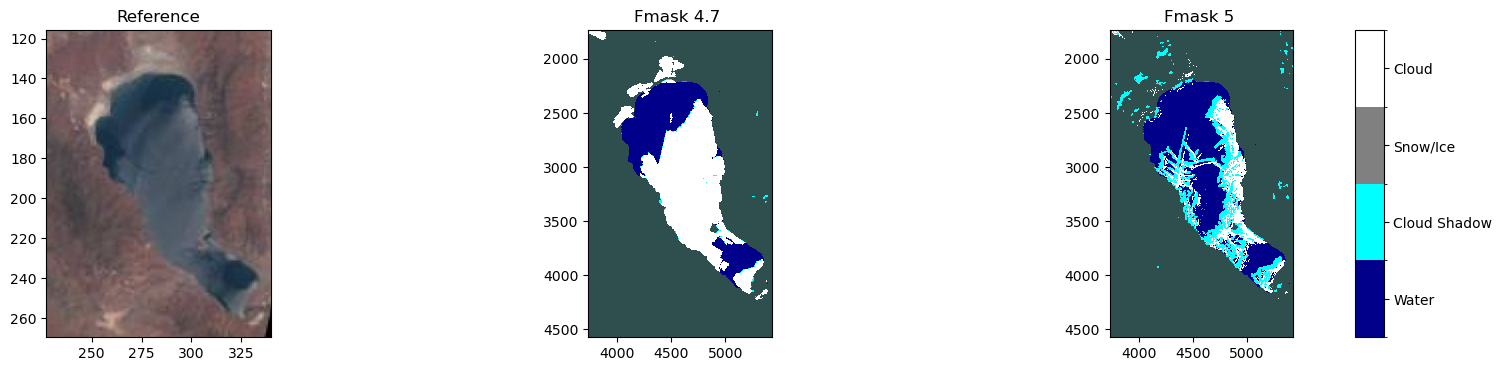

In [25]:
# A test case over dark surface 
day = days[3]
fig, axes = plt.subplots(figsize=(19.06,  3.99),
                         #sharex=True,
                         #sharey=True,
                         ncols=3)

raster_list = list()
for i in range(3):

    if i == 0:
        fmask_version = 'fmask4.7'
        title = 'Reference' 

    elif i == 1:
        fmask_version = 'fmask4.7'
        title = 'Fmask 4.7 '
        day_text = day.replace('_',' ') 

    else:
        fmask_version = 'fmask5_May2025'
        title = 'Fmask 5 '
        day_text = day.replace('_',' ') 

    ax = axes[i]

    ax.set_title(title)


    file = glob.glob(folders+fmask_version+'/'+
               '*'+day+'*.tif')[0]
    raster = rasterio.open(file).read(1).astype(np.float16)

    # mask out 255 to nan
    raster[raster == 255] = np.nan
    raster[raster == 0] = np.nan



    vmin = 0
    vmax = 4

    if i == 0:
        file_thumbnail = glob.glob(folders+fmask_version+'/'+
                   '*'+day+'*.jpg')[0]
        img = mpimg.imread(file_thumbnail,

                           )

        ax.imshow(img)

    else:
        bounds = [1,2,3,4,5]
        #default_cmap = plt.cm.viridis
        #colors_ = default_cmap(np.linspace(0, 1, len(bounds)+1))
        colors_ = ['darkblue','cyan','grey','white']
        custom_listed_cmap = colors.ListedColormap(colors_)
        custom_listed_cmap.set_bad(color='darkslategrey')

        norm = colors.BoundaryNorm(bounds,custom_listed_cmap.N)


        ax.imshow(raster,cmap=custom_listed_cmap,norm=norm,
                  interpolation='nearest')

        if i == 2:

            # Manually define the position and size of the colorbar axes (cax)
            # The arguments are [left, bottom, width, height] in figure coordinates (0 to 1)
            # Adjust these values as needed to position your colorbar
            cax = fig.add_axes([ax.get_position().x1,  # x-position (slightly to the right of the main axes)
                                ax.get_position().y0,         # y-position (aligned with the bottom of the main axes)
                                0.015,                         # width of the colorbar axes
                                ax.get_position().height])    # height of the colorbar axes (same as main axes)


            cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, 
                                                      cmap=custom_listed_cmap), 
                                boundaries=bounds, 
                                #ticks=[i + 0.5 for i in cbar.ax.get_yticks()]
                                cax=cax
                                )

            cbar.ax.set_yticks([1.5,2.5,3.5,4.5])

            cbar.ax.set_yticklabels([
                                     'Water', 
                                     'Cloud Shadow',
                                     'Snow/Ice',
                                     'Cloud',

                                     ])
axes[0].set_ylim((269.80940988835727, 115.74242424242425))
axes[0].set_xlim((227.2673358296928, 340.02650648360026))
axes[1].set_xlim((3731.927189515289, 5429.515315674844))
axes[1].set_ylim((4576.197588126159, 1734.9711453959571))
axes[2].set_xlim((3731.927189515289, 5429.515315674844))
axes[2].set_ylim((4576.197588126159, 1734.9711453959571))

The idea is similar to the urban investigation, using a fixed mrgs id and perform the comparsion of cloud shadow detection between Fmask 4.7 and 5.0